# Initialization

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys

# https://github.com/ColmTalbot/gwmemory.git
import gwmemory

from numpy.fft import fft, ifft, fftfreq
from scipy.stats import expon
import matplotlib as mpl
from scipy.signal import savgol_filter
import pickle

#Required for Parallel Computing
import ray


##Uncomment to add path
#print(sys.path)
sys.path.insert(0, "/home/toredeniz.boybeyi/LISA_Sensitivity")

#LISA_Sensitivity Modules
import PhenomA as pa
import LISA as li
import WaveformTools as wt
import LISA_tools
import LISAPhenomA
 

#import gwsurrogate
#gwsurrogate.catalog.pull('NRSur7dq4')
#sur = gwsurrogate.LoadSurrogate('NRSur7dq4')


mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = False
mpl.rcParams["grid.alpha"] = 0

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Detector Response functions 
$$F^{+}(\theta,\phi,\psi) = -\frac{1}{2} (1+\cos^2{(\theta)})\cos(2\phi)\cos(2\psi)-\cos(\theta)\sin(2\phi)\sin(2\psi)$$
$$F^{\times}(\theta,\phi,\psi) = \frac{1}{2} (1+\cos^2{(\theta)})\cos(2\phi)\cos(2\psi)-\cos(\theta)\sin(2\phi)\sin(2\psi)$$

In [3]:
def fplus(th,ph,psi):
    return -0.5*(1+np.cos(th)*np.cos(th))*np.cos(2*ph)*np.cos(2*psi)-np.cos(th)*np.sin(2*ph)*np.sin(2*psi)

def fcross(th,ph,psi):
    return 0.5*(1+np.cos(th)*np.cos(th))*np.sin(2*ph)*np.cos(2*psi)-np.cos(th)*np.sin(2*ph)*np.cos(2*psi)

# Single Event Example

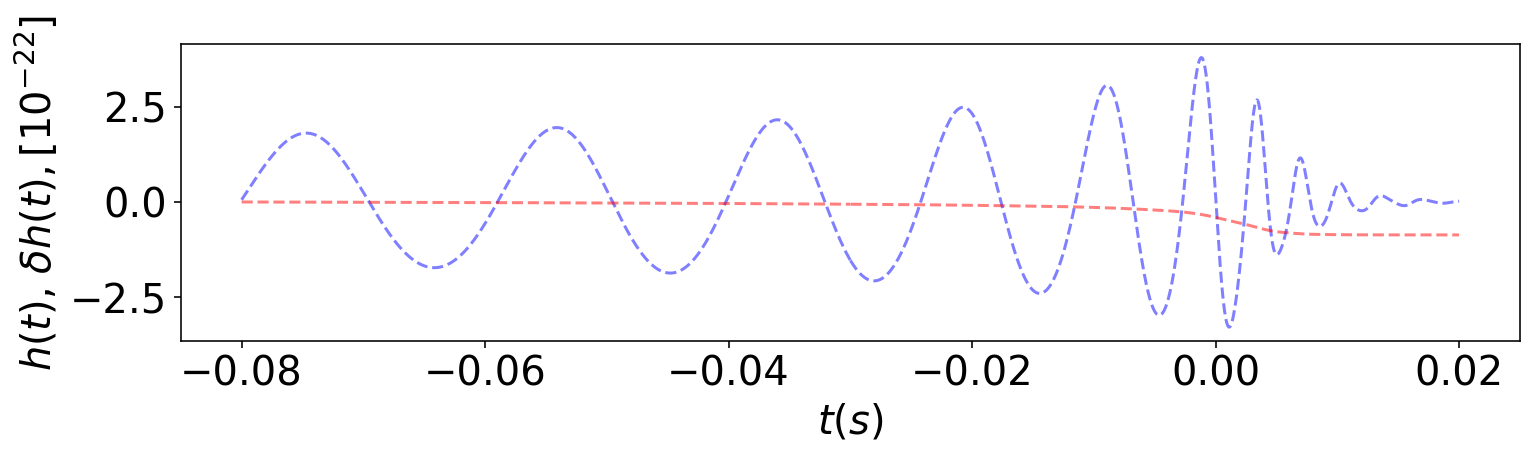

In [20]:
q = 1.
mass = 60
dist = 400
S1 = [0., 0., 0.]
S2 = [0., 0., 0.]
theta_jn=np.pi/3
dec = np.pi/2
psi = np.pi/4
ra = np.pi/3
phase = 0

times = np.linspace(-0.08, 0.02, 10001)

parameters = dict(
        q=q,spin_1=S1,spin_2=S2,total_mass=mass, distance=dist, model='NRSur7dq2',
        inc=dec, phase=phase, times = times)

surr = gwmemory.waveforms.Surrogate(q=q,spin_1=S1,spin_2=S2,total_mass=mass, distance=dist,times=times)
oscillatory, times = surr.time_domain_oscillatory(inc=dec, phase=phase)
h_mem, times = gwmemory.time_domain_memory(**parameters)

oscillatory_sky= np.multiply(oscillatory['plus'],fplus(theta_jn,psi,ra))+np.multiply(oscillatory['cross'],fcross(theta_jn,psi,ra)) 
h_sky = np.multiply(h_mem['plus'],fplus(theta_jn,psi,ra))+np.multiply(h_mem['cross'],fcross(theta_jn,psi,ra))

fig = figure(figsize=(12, 6))
fig.add_subplot(2, 1, 1)
plt.plot(times, oscillatory_sky*1e22, linestyle='--', color='b', alpha=0.5)
plt.plot(times, h_sky*1e22, linestyle='--', color='r', alpha=0.5)
plt.xlabel('$t (s)$')
plt.ylabel('$h(t)$, $\delta h(t), \\left[10^{-22}\\right]$');

# Read the List of Events from Population Data
This data is follows lastest catalog for BBH and merger rate is 30 $$Gpc^{-3} yr^{-1}$$

Data is in the standard Bilby format

The intrinsic variables are the two black hole masses $$m_1,_2$$, their dimensionless spin magnitudes $$a_1,_2$$, the tilt angle between their spins and the orbital angular momentum $$θ_1,_2$$, and the two spin vectors describing the azimuthal angle separating the spin vectors $$\phi_{12}$$ and the cone of precession about the system’s angular momentum $$\phi_{jl}$$. The extrinsic parameters are the luminosity distance $d_L$ in Mpc, the right ascension $$r_a$$ and declination $$dec$$, the inclination angle between the observers line of sight and the
orbital angular momentum $\iota$, the polarisation angle $\psi$, and the phase at coalescence $\phi_c$

Additionally $\delta t$ is the time difference in seconds between two consecutive events.

In [ ]:
event_list = []
import csv
with open('bbh_population_10_years.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        event_list.append([float(row['luminosity_distance']),float(row['mass_1'])
                           ,float(row['mass_2']),float(row['a_1']),float(row['a_2']),
                           float(row['tilt_1']),float(row['tilt_2']),float(row['phi_12']),
                           float(row['phi_jl']),float(row['dec']),float(row['ra']),
                           float(row['theta_jn']),float(row['psi']),float(row['phase']),
                           int(float(row['delta_t']))])    

# Calculate the GWMemory for Events and Join Them

In [ ]:
# Compute the GwMemory waveform and return the amplitude
def calculate_mem(dist,mass1,mass2,a1,a2,tilt_1,tilt_2,phi_12,phi_jl,dec,ra,theta_jn,psi,phase):
    distance = dist
    mass = mass1 + mass2
    q = mass1/mass2


    #Restricting the mass ratio and spin magnitudes
    #to the capability of NRSur7dq2 
    if q>2:
        q=2
    if a1>0.8:
        a1 = 0.8
    if a2>0.8:
        a2=0.8
    
    #Calculate Cartesian components of the spins
    s1 = [a1*np.sin(tilt_1)*np.cos(phi_jl+phi_12),a1*np.sin(tilt_1)*np.sin(phi_jl+phi_12),a1*np.cos(tilt_1)]
    s2 = [a2*np.sin(tilt_2)*np.cos(phi_jl-phi_12),a2*np.sin(tilt_2)*np.sin(phi_jl-phi_12),a2*np.cos(tilt_2)]

    parameters = dict(
        q=q,spin_1=s1,spin_2=s2,total_mass=mass, distance=distance, model='NRSur7dq2',
        inc=dec, phase=phase, times = np.linspace(-0.0004*mass, 0.0004*mass, 1001))

    # Calculate the Memory waveform
    h_mem, times = gwmemory.time_domain_memory(**parameters)
    #Project Memory to the detector
    h_sky = np.multiply(h_mem['plus'],fplus(theta_jn,psi,ra))+np.multiply(h_mem['cross'],fcross(theta_jn,psi,ra))    
    
    return h_sky[-1]-h_sky[0]
    
    
calculate_mem_remote = ray.remote(calculate_mem)


# Event_count is the number of CBC events to be simulated
if __name__ == "__main__":
    ray.shutdown()
    ray.init(num_cpus=40)
    event_count = 100
    results = ray.get([calculate_mem_remote.remote(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],
                      row[8],row[9],row[10],row[11],row[12],row[13])
                      for row in event_list[0:event_count]])

# Join the individual Memory Signals together
masterwave=[0]
mastertimes=[0] 
    for i in range(event_count):
        N = event_list[i][-1]
        masterwave=numpy.concatenate([masterwave,[masterwave[-1]+results[i]]])
        mastertimes=numpy.concatenate([mastertimes,[mastertimes[-1]+1]])
        waveadd= np.linspace(masterwave[-1],masterwave[-1],N)
        timeadd= np.linspace(mastertimes[-1],mastertimes[-1]+N,N)
        masterwave=numpy.concatenate([masterwave,waveadd])
        mastertimes=numpy.concatenate([mastertimes,timeadd])

## Plot the time domain Memory Signals
#plt.xlabel('$t (s)$')
#plt.ylabel('$\delta h \, \left[10^{-22}\\right]$')
#plt.plot(mastertimes[1:],masterwave[1:]*1e22)
#plt.show()

##Write the waveform to a file
## Adjust the file name accordingly
dic = {}
dic["time"] = mastertimes
dic["wave"] = masterwave
with open('wave100.p', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


ray.shutdown()

# Read the GWMemory Time-Domain Waveform

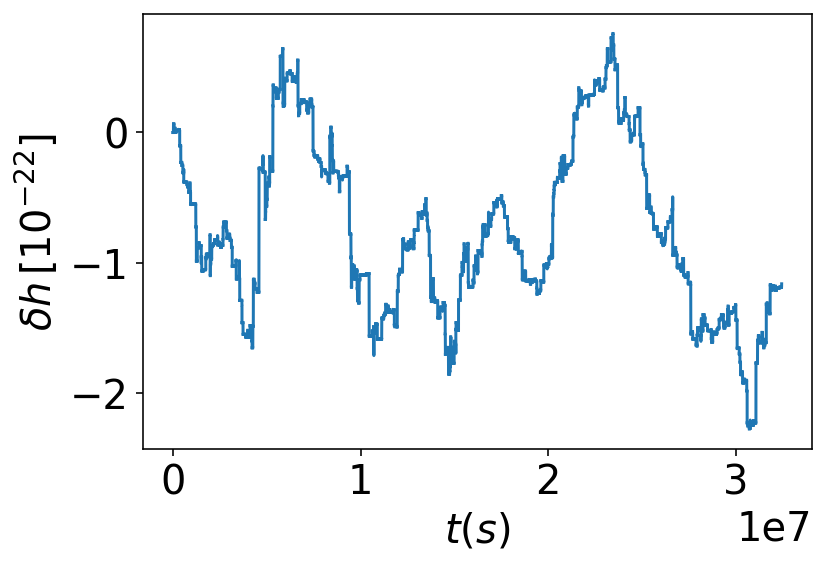

In [17]:
#File name indicates how many individual events are simulated
dic1 = pickle.load(open("wave100.p","rb"))
mastertimes = dic1["time"]  
masterwave = dic1["wave"] 

# Plot the Total time domain Memory Signal
plt.xlabel('$t (s)$')
plt.ylabel('$\delta h \, \left[10^{-22}\\right]$')
plt.plot(mastertimes[1:],masterwave[1:]*1e22)
plt.show()

In [5]:
# Calculate LISA's sensitivity curve
lisa = li.LISA() 
f  = np.logspace(np.log10(1.0e-5), np.log10(1.0e0), 1000)
Sn = lisa.Sn(f)

# Calculate PSD and Strain
$$S_{psd}(f) = \frac{1}{T} \int dt h^2(t)  = \frac{1}{T} \Big|\int^T_0 dt e^{i2\pi f t} h(t) \Big|^2 $$
$$h_{c}(f) = \sqrt(2fS_{psd})$$

In [18]:
def psd(sample_rate, wave):
    length = len(wave)
    f = fftfreq(length, 1/sample_rate)
    duration = int(sample_rate * length)
    wave_f = np.abs(fft(wave))
    
    #Return positive frequency parts
    return f[:length//2], 1/duration*np.multiply(wave_f,wave_f)[:length//2]

    
def strain(sample_rate,wave):
    f, wave_psd = psd(sample_rate, wave)
    strain = np.sqrt(f*wave_psd)
    return f, strain


sample_rate = 1.0
xf, hc = strain(sample_rate,masterwave)

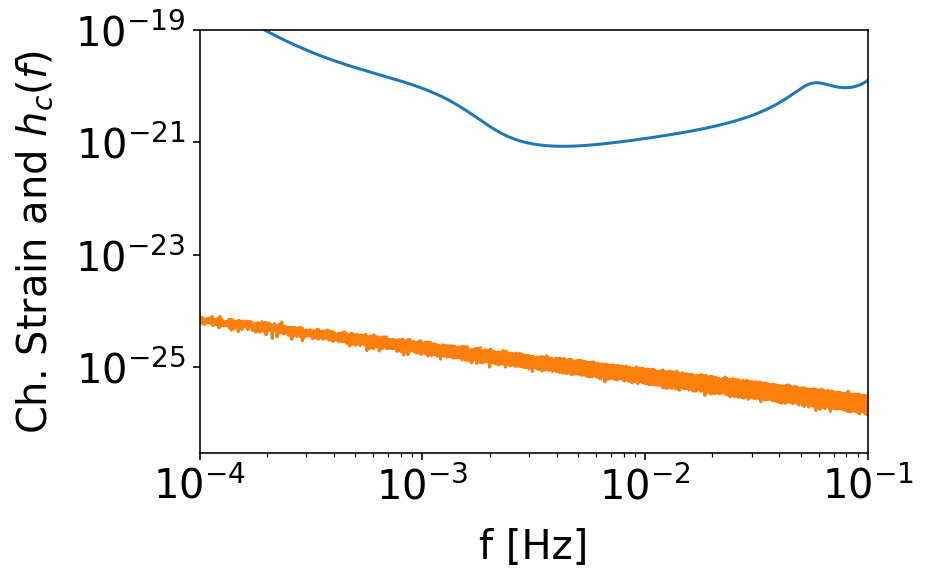

In [19]:
#Plot Memory Strain and LISA Characteristic Strain Together
fig, ax = plt.subplots(1, figsize=(6,4))
plt.tight_layout()

ax.set_xlabel(r'f [Hz]', fontsize=20, labelpad=10)
ax.set_ylabel(r'Ch. Strain and $h_c(f)$', fontsize=20, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=20)
    
ax.set_xlim(1.0e-4, 1.0e-1)
ax.set_ylim(3.0e-27, 1.0e-19)

ax.loglog(f, np.sqrt(f*Sn))


#Apply Savitzky-Golay Filter to the strain
ax.loglog(xf,savgol_filter(hc,100,4))